In [14]:
#Steven Zajac-Descoteaux

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.stats.api as sms

# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

In [15]:
def compare_model(X,y):
    
    return sm.OLS(y,X).fit().summary()

tennis = pd.read_csv('data/tennis.csv')


X = tennis[['player2 total points won']]
X = X.dropna()
X = sm.add_constant(X)

y = tennis[['player1 total points won']]
y = y.dropna()

est = sm.OLS(y,X).fit(cov_type='HC2')

est.summary()
#sm.graphics.plot_fit(est, y)


# The coef for Player2 total points is of 0.8199. Meaning that opponents score 0.8199 more points for every 1 point
# that Federer scores. The p-value is also 0 which tells is it is statistically significant and can reject
# the null hypothesis. If we look at the R-squared without a constant, it is higher than it is with. However, it 
# becomes uncentered. Futhermore, the AIC and BIC also go down as we add a contant to our model. That being said
# generally a constant should be added to a model for added dimension

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.794
Model:                                  OLS   Adj. R-squared:                  0.794
Method:                       Least Squares   F-statistic:                     4079.
Date:                      Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                              10:34:06   Log-Likelihood:                -4062.7
No. Observations:                      1027   AIC:                             8129.
Df Residuals:                          1025   BIC:                             8139.
Df Model:                                 1                                         
Covariance Type:                        HC2                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       26.2630      0.917     28.634      0.000      24.465      28.061
player2 total points won     0.8199      0.013     63.870      0.000       0.795       0.845
==============================================================================
Omnibus:                       78.409   Durbin-Watson:                   1.378
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.799
Skew:                          -0.640   Prob(JB):                     2.89e-23
Kurtosis:                       3.888   Cond. No.                         211.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:              Top25perc   R-squared:                       0.852
 Model:                            OLS   Adj. R-squared:                  0.851
 Method:                 Least Squares   F-statistic:                     2220.
 Date:                Sat, 16 Jan 2021   Prob (F-statistic):          2.50e-321
 Time:                        10:34:07   Log-Likelihood:                -2681.0
 No. Observations:                 777   AIC:                             5368.
 Df Residuals:                     774   BIC:                             5382.
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

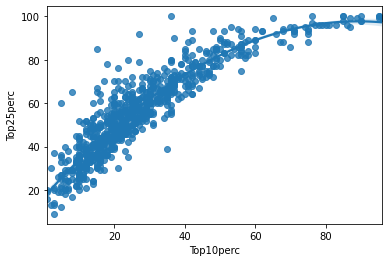

In [16]:
#2.1

college = pd.read_csv('data/college.csv')

#Df for top10perc and top10perc_sq
top10 = college[['Top10perc']] #Top10perc only
top10_sq = top10.apply(np.square) #Top10perc sq
top10_sq.columns = top10.columns+"_sq"
top10sq = pd.concat((top10,top10_sq),axis=1)

#Constant adding
con_top10 = sm.add_constant(top10) #Top10perc with constnat
con_top10_sq = sm.add_constant(top10_sq) #
full_df = sm.add_constant(pd.concat((top10, top10_sq),axis=1)) #Top10perc + Top10perc_sq + constant

y = college[['Top25perc']]

def compare_model(df,y):
    
    return sm.OLS(y,df).fit().summary(),sns.regplot(data=college,x=top10,y="Top25perc",order=2)

compare_model(full_df,y) 

#The relation between Top10perc and top25perc is best fit when using a constant and a polynomial degree of 2. 
# Using a polynomial, the AIC and BIC and the Log-Likelihood goes down. Furthermore the R2 goes up. 
#Interestingly the R2 goes down when including a constant but the Log-likelihood and teh AIC and BIC are 
#reduced when including a constant.

In [17]:
#2.2
college = pd.read_csv('data/college.csv')
#college.corr()

college.Private = college.Private.eq('Yes').mul(1) #Converts yes to 1 and no to 0
X = college.Private
X = sm.add_constant(X)

y = college.Accept

est = sm.OLS(y,X).fit(cov_type='HC2')

#sns.regplot(x='Private',y='Accept',data=college)

est.summary()

#Here private colleges see less admissions than public ones overall. This can be observed with the coefficient of
# -2613.59

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Accept   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     113.2
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           9.15e-25
Time:                        10:34:07   Log-Likelihood:                -7066.5
No. Observations:                 777   AIC:                         1.414e+04
Df Residuals:                     775   BIC:                         1.415e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3919.2877    238.820     16.411      0.000    3451.210    4387.366
Private    -2613.5851    245.672    -10.639      0.000   -3095.093   -2132.077
==============================================================================
Omnibus:                      603.909   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15927.055
Skew:                           3.268   Prob(JB):                         0.00
Kurtosis:                      24.195   Cond. No.                         3.60
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
 ii. How strong is the relationship between the predictor and the response?
 
 iii. Is the relationship between the predictor and the response positive or negative?

 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

 v. Make a regression plot the response and the predictor.

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                    mpg   R-squared:                       0.606
 Model:                            OLS   Adj. R-squared:                  0.605
 Method:                 Least Squares   F-statistic:                     599.7
 Date:                Sat, 16 Jan 2021   Prob (F-statistic):           7.03e-81
 Time:                        10:34:08   Log-Likelihood:                -1178.7
 No. Observations:                 392   AIC:                             2361.
 Df Residuals:                     390   BIC:                             2369.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

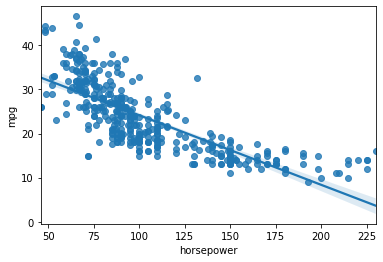

In [18]:
#i. Is there a relationship between the predictor and the response?

auto = pd.read_csv('data/auto.csv',sep='\s+')

auto.dropna(inplace=True)
auto.reset_index(drop=True,inplace=True)
drops = list(auto.index[auto['horsepower']=='?']) #Drop indices where ?
auto.drop(drops,inplace=True)

auto[['mpg','horsepower']] = auto[['mpg','horsepower']].astype(float)

#Simple regression:

def model(X,y):
    return sm.OLS(y,X).fit().summary(),sns.regplot(data=auto,y='mpg',x='horsepower',order=1)

X = auto.horsepower
X = sm.add_constant(X)

y = auto.mpg

est = sm.OLS(y,X).fit(cov_type='HC2')

#x_hat = np.linspace(X.min(),X.max())
#y_hat = est.predict(x_hat)

#plt.plot(x_hat[:,1],y_hat)
#plt.scatter(X.horsepower,y)
#plt.show()
model(X,y)

#Yes there's a relationship between mpg and horsepower. (Negative one). Horsepower decreases as
# mpg increases. At a rate of -0.1578 in mpg for every 1 increase in horsepower. Also the p value is less
#than 0.05 and thus confirming the negative relationship 

In [19]:
#ii. How strong is the relationship between the predictor and the response?

#There's a medium-strong correlation between horsepower and mpg. The R-squared is of 0.606

In [20]:
#iii. Is the relationship between the predictor and the response positive or negative?

#The relationship between predictor and response is negative. 

In [21]:
#iv. What is the predicted mpg associated with a horsepower of 98? 
# What are the associated 95 % confidence and prediction intervals ?

#Get coeff
def model(X,y):
    est = sm.OLS(y,X).fit()
    return est.summary(), est.conf_int(alpha=0.05),est.predict([1,98])#Alpha 0.05 for 95% 
    #Predict needs same shape in order to work. 

X = auto.horsepower
X = sm.add_constant(X)

y = auto.mpg

#Set up variabls
β = -0.1578 #Horsepower coeff
x = 98      #Privided value
α = 39.9359 #Constant coeff 


Y = β * x + α
Y #mpg prediction
model(X,y),Y #Very slight difference 24.4670 and 24.4715

#Since the confidence intervals is bweteen -0.171 up to -0.145 



((<class 'statsmodels.iolib.summary.Summary'>
  """
                              OLS Regression Results                            
  Dep. Variable:                    mpg   R-squared:                       0.606
  Model:                            OLS   Adj. R-squared:                  0.605
  Method:                 Least Squares   F-statistic:                     599.7
  Date:                Sat, 16 Jan 2021   Prob (F-statistic):           7.03e-81
  Time:                        10:34:09   Log-Likelihood:                -1178.7
  No. Observations:                 392   AIC:                             2361.
  Df Residuals:                     390   BIC:                             2369.
  Df Model:                           1                                         
  Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
  -------------------------------------------------------

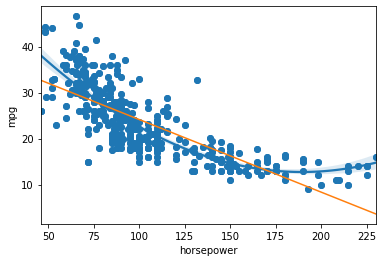

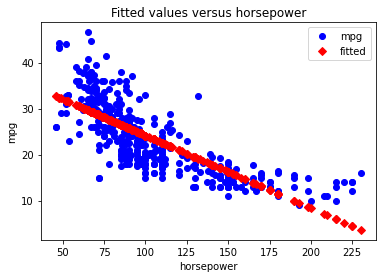

In [22]:
#v. Make a regression plot the response and the predictor.

#Degree two (I know not linear but wanted to check)
sns.regplot(data=auto,y='mpg',x='horsepower',order=2) #Plots regression 


#Answer
X = auto.horsepower
X = sm.add_constant(X)

y = auto.mpg

est = sm.OLS(y,X).fit()

x_hat = np.linspace(X.min(),X.max())
y_hat = est.predict(x_hat)

plt.plot(x_hat[:,1],y_hat)
plt.scatter(X.horsepower,y)
plt.show()


sm.graphics.plot_fit(est, 'horsepower', vlines=False); #Other graph

# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

v. Is there heteroscedasticity in the fit?

In [23]:
auto = pd.read_csv('data/auto.csv',sep='\s+')

auto.dropna(inplace=True)
auto.reset_index(drop=True,inplace=True)
drops = list(auto.index[auto['horsepower']=='?']) #Drop indices where ?
auto.drop(drops,inplace=True)

auto[['mpg','horsepower']] = auto[['mpg','horsepower']].astype(float)


X = auto.drop(['name','mpg'],axis=1) #Drop name and mpg (y)
y = auto.mpg
X = sm.add_constant(X) #Adds constant

est = sm.OLS(y,X).fit(cov_type='HC2')

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.5
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          1.98e-139
Time:                        10:34:10   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:                  HC2                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.697     -3.666      0.000     -26.425      -8.012
cylinders       -0.4934      0.311     -1.586      0.113      -1.103       0.116
displacement     0.0199      0.008      2.401      0.016       0.004       0.036
horsepower      -0.0170      0.014     -1.208      0.227      -0.044       0.011
weight          -0.0065      0.001     -8.304      0.000      -0.008      -0.005
acceleration     0.0806      0.128      0.630      0.529      -0.170       0.331
year             0.7508      0.049     15.196      0.000       0.654       0.848
origin           1.4261      0.275      5.187      0.000       0.887       1.965
==============================================================================
Omnibus:                       31.906   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.100
Skew:                           0.529   Prob(JB):                     2.95e-12
Kurtosis:                       4.460   Cond. No.                     8.59e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 8.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#i. Is there a relationship between the predictors and the response?

#Since horsepower's p-value is greater than 0.05 we can understand that change in mpg can be better explained by
# other features and thus drop features with p-values greater than 0.05. So in all, there is a relationship between
# predictors and response. However, cylinders, horsepower and acceleration are not good predictors for mpg. 

In [25]:
##ii. Which predictors appear to have a statistically significant relationship to the response?

#The test shows that all predictors appear to have a statistically significant relationship to the response. 
# Except for acceleration, cylinders and horsepower...since their p-values are greater than 0.05.
# This means that other predictors contribute to a better prediction of mpg than acceleration, cylinders, and
# horsepower

In [26]:
#iii. What does the coefficient for the year variable suggest?

#The coefficient for the year means that for every 1 increase in year, there is a 0.7508 increase in mpg

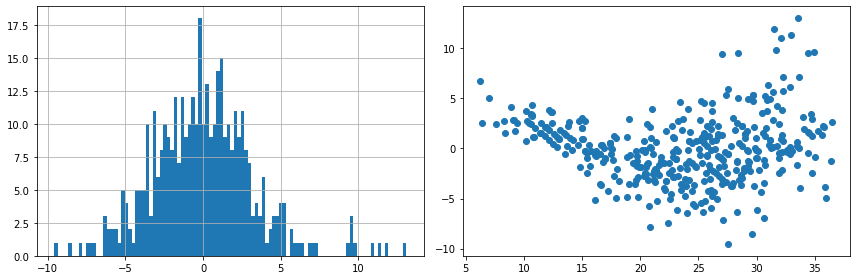

In [27]:
#iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

est.summary()

fix, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
est.resid.hist(bins=100,ax=ax1)
plt.scatter(x=est.predict(X),y=est.resid)
plt.tight_layout()

# Looking at the histogram the distribution seems to have a longer tail to the right. We can see a few
# outliers. 

In [28]:
#v. Is there heteroscedasticity in the fit?


#https://www.statology.org/breusch-pagan-test-python/
#https://www.statsmodels.org/stable/diagnostic.html
# Null hypothesis: Homoscedasticity present
# Alt. hypothesis: Homoscedasticity not present (heteroscedasticity exists)
#p-value < 5...accept null hypothesis
import statsmodels.stats.api as sms

X = auto.drop(['name','mpg'],axis=1) #Drop name and mpg (y)
X = sm.add_constant(X) #Adds constant

y = auto.mpg

est = sm.OLS(y,X).fit(cov_type='HC2')
est.summary()

_,pval,__,f_pval = sm.stats.diagnostic.het_breuschpagan(est.resid,X)#Works multiple and lin
pval,f_pval

#p value being less than 0.05 we can safely reject the null hypothesis and there is heteroscedasticity
# in the model. 


(0.0001184324373909795, 8.683259637573102e-05)

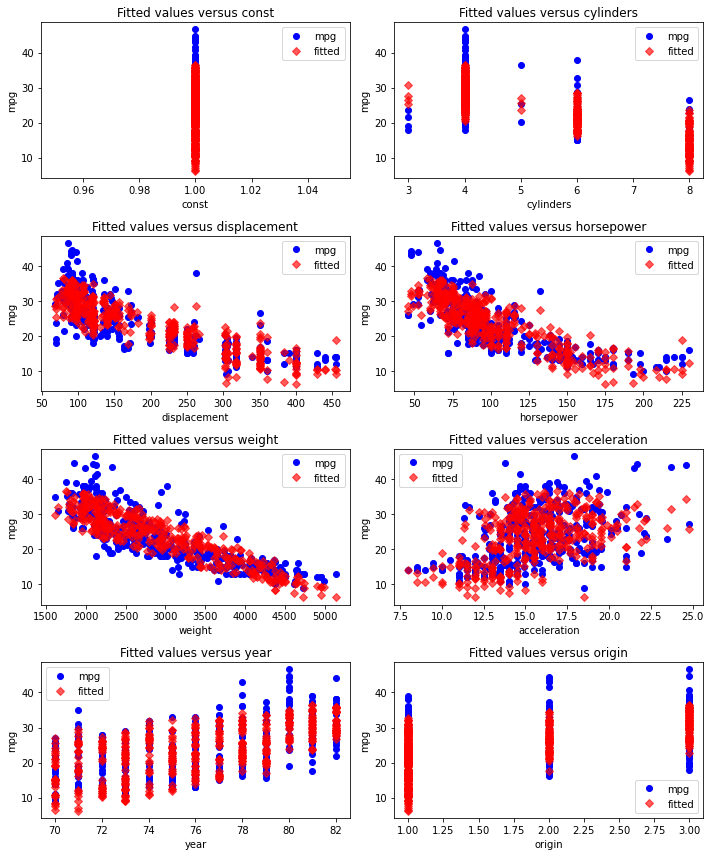

In [29]:
#Shows fitted values vs observed values. 
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(figsize=(10,12),nrows=4,ncols=2)
sm.graphics.plot_fit(est, 0,ax=ax1, vlines=False, alpha = .65)
sm.graphics.plot_fit(est, 1,ax=ax2, vlines=False, alpha = .65)
sm.graphics.plot_fit(est, 2,ax=ax3, vlines=False, alpha = .65)
sm.graphics.plot_fit(est, 3,ax=ax4, vlines=False, alpha = .65)
sm.graphics.plot_fit(est, 4,ax=ax5, vlines=False, alpha = .65)
sm.graphics.plot_fit(est, 5,ax=ax6, vlines=False, alpha = .65)
sm.graphics.plot_fit(est, 6,ax=ax7, vlines=False, alpha = .65)
sm.graphics.plot_fit(est, 7,ax=ax8, vlines=False, alpha = .65)
plt.tight_layout()


In [30]:
#sns.residplot(x='horsepower', y='mpg', data=auto) #Residuals for linear regression. One feature at a time

In [31]:

"""#Regression plot for residual?
X = auto.drop(['name','mpg'],axis=1) #Drop name and mpg (y)
y = auto.mpg
X = sm.add_constant(X) #Adds constant

est = sm.OLS(y,X).fit()

est.summary()
y_pred = est.predict(X) #Looking at difference between observed and predicted valus so same X

residual = y - y_pred
sns.regplot(x = residual, y = y_pred,data=auto)"""

"#Regression plot for residual?\nX = auto.drop(['name','mpg'],axis=1) #Drop name and mpg (y)\ny = auto.mpg\nX = sm.add_constant(X) #Adds constant\n\nest = sm.OLS(y,X).fit()\n\nest.summary()\ny_pred = est.predict(X) #Looking at difference between observed and predicted valus so same X\n\nresidual = y - y_pred\nsns.regplot(x = residual, y = y_pred,data=auto)"

# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [32]:
car_seat = pd.read_csv('data/carseats.csv')
#car_seat.info()
car_seat

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [33]:
# 1.Fit a multiple regression model to predict Sales using Price, Urban, and US.
car_seat = pd.read_csv('data/carseats.csv') 
car_seat[['Urban','US']] = car_seat[['Urban','US']].eq('Yes').mul(1) #Binary 


#Multiple Regression

y = car_seat.Sales

X = car_seat[['Price','Urban','US']]
X = sm.add_constant(X) #Add constant

est = sm.OLS(y,X).fit(cov_type='HC2')

est.summary()


# 2. Provide an interpretation of each coefficient in the model.
# Be careful—some of the variables in the model are qualitative!

#Y-intercept: if all other predictors are set to 0, sales remains at 13.0435
#Price: For every positive change in Price we can see a negative change in Sales (-0.0545)
#Urban: P-value is not good (> 0.05) and thus is not a statistically significant coefficient
#       (-.0219 sales in urban areas. If it was correlated)
#US: Good P-value, positively correlated (1.2006). Hinting that sales in the US are 1.2006 times higher



# 3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

#We can reject the null hypothesis for all predictors EXCEPT Urban. P-value is greater than .05


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     43.09
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           4.04e-24
Time:                        10:34:12   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.641     20.333      0.000      11.786      14.301
Price         -0.0545      0.005    -10.515      0.000      -0.065      -0.044
Urban         -0.0219      0.258     -0.085      0.932      -0.527       0.484
US             1.2006      0.246      4.878      0.000       0.718       1.683
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [34]:
# 4. On the basis of your response to the previous question, fit a smaller model
# that only uses the predictors for which there is evidence of association with the outcome

car_seat = pd.read_csv('data/carseats.csv') 
car_seat['US'] = car_seat['US'].eq('Yes').mul(1) #Binary 


#Multiple Regression

y = car_seat.Sales

X = car_seat[['Price','US']]
X = sm.add_constant(X) #Add constant

est = sm.OLS(y,X).fit(cov_type='HC2')

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     64.66
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           4.90e-25
Time:                        10:34:12   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.622     20.944      0.000      11.811      14.250
Price         -0.0545      0.005    -10.543      0.000      -0.065      -0.044
US             1.1996      0.247      4.863      0.000       0.716       1.683
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [35]:
# 5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

#The models in question 1 and 4 has a few obvious differences. At first if we look at the AIC and BIC, they both drop
# a few points in the smaller model. The adjusted R-squared got slightly better in the second model. The condition 
# number also went down. The omnibus also goes down in the second model and the Prob(Omnimous goes up (closer to 1)).
# 

In [36]:
# 6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s)

car_seat = pd.read_csv('data/carseats.csv') 
car_seat['US'] = car_seat['US'].eq('Yes').mul(1) #Binary 


#Multiple Regression

y = car_seat.Sales

X = car_seat[['Price','US']]
X = sm.add_constant(X) #Add constant

est = sm.OLS(y,X).fit(cov_type='HC2')

est.conf_int(alpha=0.05) #Confidence interval 95% = 0.05

,0,1
const,11.811364,14.250221
Price,-0.064605,-0.044350
US,0.716136,1.683150
